EchoLab Data Quest - Eyrin Kim

Notebook steps:

1. Set parameters in configuration
2. Data helper functions (extracting subsets, transforming data)
3. Load EuroSAT data
4. MOSAIKS model implementation
5. ResNet model implementation
6. Image states model implementation
7. Feature extraction code
8. Initialize models
9. Extract features
10. Save features & labels
11. Evaluate based on logistic regression multi-class classifier
12. Visualize embeddings

In [21]:
#!pip install torchgeo[datasets] torchview matplotlib tqdm scikit-learn

In [22]:
# imports

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
from torchgeo.datasets import EuroSAT
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
import gc
warnings.filterwarnings('ignore')

In [23]:
# main configuration - toggle these for runtime/memory

class Config:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.data_dir = './data'
        self.output_dir = './embeddings'
        self.checkpoint_path = "B3_rn18_moco_0099_ckpt.pth" # from https://github.com/zhu-xlab/SSL4EO-S12?tab=readme-ov-file

        # dataset parameters - ADJUST THESE FOR MEMORY
        self.use_full_dataset = False # set to False to use subset
        self.samples_per_class = 250 # adjust for colab RAM, 250 is reasonable

        # model parameters
        # Note: Paper uses 8192 but assignment specifies size 512
        self.num_features = 512 # feature dimension for all models
        self.mosaiks_patch_size = 3 # paper uses 3x3x3
        self.input_channels = 3

        # training parameters - ADJUST FOR MEMORY
        self.batch_size = 32
        self.num_workers = 0

        # image preprocessing (paper coarsens to 256x256, page 17 of supp.)
        self.image_size = 256
        self.crop_size = 224

config = Config()
os.makedirs(config.output_dir, exist_ok=True)

In [24]:
# data helper functions

def create_stratified_subset(dataset, samples_per_class=100):
    """
    create stratified sample if compute is limited
    """
    num_classes = len(dataset.classes)
    print(f"Dataset has {num_classes} classes: {dataset.classes}")

    # dict to hold the indices for each class, efficient sample grouping
    class_indices = {i: [] for i in range(num_classes)}

    # iterate through the entire dataset once to get all labels
    for idx in tqdm(range(len(dataset))):
        try:
            sample = dataset[idx]
            # handle dictionary format, TorchGeo datasets return dictionaries
            if isinstance(sample, dict):
                label = sample.get('label', sample.get('labels'))
            else: # handle standard tuple format (e.g., torchvision datasets)
                _, label = sample

            # convert tensor to int if needed
            if torch.is_tensor(label):
                label = label.item()

            class_indices[label].append(idx)

        except Exception as e:
            print(f"Error at index {idx}: {e}")
            continue

    for class_idx, indices in class_indices.items():
        print(f"Class {class_idx} ({dataset.classes[class_idx]}): {len(indices)} samples")

    # sample from each class
    indices_to_keep = []
    for class_idx, indices in class_indices.items():
        if len(indices) == 0:
            print(f"Warning: Class {class_idx} has no samples")
            continue

        num_to_sample = min(samples_per_class, len(indices))
        if num_to_sample < samples_per_class:
            print(f"Note: Class {class_idx} has only {len(indices)} samples (tried for {samples_per_class})")

        # without replacement to get unique samples
        sampled = np.random.choice(indices, size=num_to_sample, replace=False)
        indices_to_keep.extend(sampled)

    print(f"Created subset!")
    return Subset(dataset, indices_to_keep)

class TransformedDataset(Dataset):
    """
    Wrapper to apply transforms to any dataset
    Useful because some datasets (like torchgeo's) don't have a `transform` argument in their constructor
    """
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        sample = self.base_dataset[idx] # get the original sample from the base dataset.

        # handle both dictionary (torchgeo) and tuple (torchvision) formats
        if isinstance(sample, dict):
            image = sample['image']
            label = sample.get('label', sample.get('labels', 0))
        else:
            image, label = sample

        # convert label to scalar if it's a tensor
        if torch.is_tensor(label):
            label = label.item()

        # apply transform
        if self.transform:
            image = self.transform(image)

        return image, label

print("Data helpers defined")

Data helpers defined


In [25]:
# load EuroSAT dataset

eurosat_full = EuroSAT(root=config.data_dir, download=True, bands=EuroSAT.rgb_bands) #RGB, not 13 band
print(f"Loaded {len(eurosat_full)} images")
print(f"Classes: {eurosat_full.classes}")

# create dataset subset if needed
if config.use_full_dataset:
    eurosat_dataset = eurosat_full
    print(f"Using full dataset: {len(eurosat_dataset)} images")
else:
    eurosat_dataset = create_stratified_subset(eurosat_full, config.samples_per_class)
    print(f"Using stratified subset: {len(eurosat_dataset)} images")

# clear memory to free RAM!!
del eurosat_full
gc.collect()

Loaded 16200 images
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Dataset has 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


100%|██████████| 16200/16200 [01:48<00:00, 148.82it/s]


Class 0 (AnnualCrop): 1791 samples
Class 1 (Forest): 1787 samples
Class 2 (HerbaceousVegetation): 1799 samples
Class 3 (Highway): 1505 samples
Class 4 (Industrial): 1492 samples
Class 5 (Pasture): 1195 samples
Class 6 (PermanentCrop): 1481 samples
Class 7 (Residential): 1863 samples
Class 8 (River): 1460 samples
Class 9 (SeaLake): 1827 samples
Created subset!
Using stratified subset: 2500 images


18104

In [26]:
# set up image transform pipeline

transform = transforms.Compose([
    # resize images to a fixed size for model consistency. `antialias=True` is for better quality
    transforms.Resize((config.image_size, config.image_size), antialias=True),
    # center crop to final desired size
    transforms.CenterCrop(config.crop_size),
    # std transformation for CNN input https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
    transforms.Lambda(lambda x: x.float() / 255.0) # scale pixel values from [0, 255] to [0.0, 1.0]
])

print("Transform defined")

Transform defined


In [27]:
class MOSAIKS(nn.Module):
    """
    MOSAIKS: Multi-task Observation using Satellite Imagery & Kitchen Sinks
    From Rolf et al. (2021)

    This implementation applies ZCA whitening as a one-time operation to the random patches that form the convolutional filters,
    as described in the supplemental paper.
    """
    def __init__(self, num_features=512, patch_size=3, input_channels=3):
        super().__init__()
        self.num_features = num_features
        self.patch_size = patch_size
        self.input_channels = input_channels
        self.patch_dim = input_channels * patch_size * patch_size

        # "a ReLU activation function with bias bk = 1 is applied."
        self.bias = nn.Parameter(torch.ones(num_features), requires_grad=False)

        # buffers to store the non-trainable filters and whitening matrix
        self.register_buffer('random_filters', None)
        self.register_buffer('whitening_matrix', None)

    def _zca_whiten(self, X, epsilon=1e-5):
        """
        Applies ZCA whitening to a 2D tensor of flattened patches.
        X shape: [num_patches, patch_dim]
        Sources: ChatGPT,
        http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/
        https://medium.com/data-science/pca-whitening-vs-zca-whitening-a-numpy-2d-visual-518b32033edf
        """
        # Center the data
        X_centered = X - X.mean(dim=0, keepdim=True)

        # Compute the covariance matrix
        cov = torch.mm(X_centered.t(), X_centered) / (X_centered.size(0) - 1)

        # Eigendecomposition of the covariance matrix
        # Using SVD for numerical stability
        U, S, V = torch.svd(cov)

        # Calculate the ZCA whitening matrix
        # ZCA = U * diag(1/sqrt(S + epsilon)) * U^T
        S_inv_sqrt = torch.diag(1.0 / torch.sqrt(S + epsilon))
        whitening_matrix = torch.mm(torch.mm(U, S_inv_sqrt), U.t())

        # Apply the whitening matrix to the centered data
        # This is the "right multiplication" mentioned in supplemental paper's footnote 14.
        X_whitened = torch.mm(X_centered, whitening_matrix)

        return X_whitened, whitening_matrix

    def initialize_filters(self, dataset, transform=None, num_patches_to_sample=None):
        """
        Samples patches, computes ZCA whitening, and creates the final frozen filters.
        This is the main, one-time setup function for the model.
        Sources: ChatGPT, same as _zca_whiten
        """
        if num_patches_to_sample is None:
            num_patches_to_sample = self.num_features // 2 # "we draw K/2 small sub-image 'patches'"

        num_images_to_use = min(1000, len(dataset))
        indices = np.random.choice(len(dataset), num_images_to_use, replace=False)

        # collect patches
        patches_list = []
        with torch.no_grad():
            for idx in tqdm(indices[:num_patches_to_sample], desc="Extracting patches"):
                sample = dataset[idx]
                if isinstance(sample, dict): # deals with both torchgeo and torchvision data formats
                    image = sample['image']
                else:
                    image, _ = sample

                # apply transform
                if transform:
                    image = transform(image)

                # extract a random patch
                h, w = image.shape[1] - self.patch_size + 1, image.shape[2] - self.patch_size + 1
                if h > 0 and w > 0:
                    i = np.random.randint(0, h)
                    j = np.random.randint(0, w)
                    patch = image[:, i:i+self.patch_size, j:j+self.patch_size]
                    patches_list.append(patch.flatten())

        if len(patches_list) == 0:
            raise ValueError("No patches were extracted. Check image dimensions and patch size.")

        patches_flat = torch.stack(patches_list).float() # Shape: [num_patches, patch_dim]

        # whiten
        whitened_patches, whitening_matrix = self._zca_whiten(patches_flat)
        self.whitening_matrix = whitening_matrix

        # create convolutional filters
        all_patches = torch.cat([whitened_patches, -whitened_patches], dim=0) # "calculate the negative of each patch to get another k patches"
        # ensure we have the exact number of features required
        final_patches = all_patches[:self.num_features]

        # Reshape from [num_features, patch_dim] to [num_features, C, H, W]
        # This creates the weights for the nn.Conv2d layer.
        self.random_filters = final_patches.view(
            self.num_features,
            self.input_channels,
            self.patch_size,
            self.patch_size
        )

    def forward(self, x):
        """
        Performs the forward pass using the pre-computed, whitened filters
        """
        if self.random_filters is None:
            raise RuntimeError("Model filters have not been initialized. "
                               "Please call `model.initialize_filters(dataset)` first.")

        # convolve the input image with the pre-whitened random filters
        conv_out = F.conv2d(x, self.random_filters, bias=self.bias)

        # apply ReLU activation per paper
        activated = F.relu(conv_out)

        # global average pooling, ...inner product values are then averaged across the entire image..."
        # aggregates the spatial information from the activation maps into a fixed-size vector
        features = F.adaptive_avg_pool2d(activated, (1, 1))
        return features.view(features.size(0), -1)

print("MOSAIKS model defined")

MOSAIKS model defined


In [28]:
class ResNetFeatureExtractor(nn.Module):
    """
    ResNet-18 with SSL4EO pre-trained weights
    From https://github.com/zhu-xlab/SSL4EO-S12?tab=readme-ov-file
    Source: https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    def __init__(self, checkpoint_path=None, input_channels=3):
        super().__init__()

        # load ResNet-18 architecture, we use custom weights
        self.backbone = models.resnet18(weights=None)

        # modify first conv layer for input channels - using RGB but in case you choose 13-band later
        self.backbone.conv1 = nn.Conv2d(
            input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        # load SSL4EO weights
        state_dict = torch.load(checkpoint_path, map_location='cpu')
        self.backbone.load_state_dict(state_dict, strict=False) # strict=False allows loading weights even if some layers don't match

        # remove classification head to get features
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity() # nn.Identity() is a placeholder layer that simply passes the input through

    def forward(self, x):
        return self.backbone(x)

print("ResNet model defined")

ResNet model defined


In [29]:
class ImageStatsModel(nn.Module):
    """
    Simple baseline using image statistics
    Mean, std, min, max
    """
    def __init__(self, target_dim=512, input_channels=3):
        super().__init__()
        self.target_dim = target_dim
        self.input_channels = input_channels
        self.base_features = 4 * input_channels # mean, std, min, max per channel

    def forward(self, x):
        b, c, h, w = x.shape # get batch size + # channels

        # reshape from (B, C, H, W) to (B, C, H*W) to easily compute stats over pixels
        x_flat = x.view(b, c, -1)

        mean = x_flat.mean(dim=2)
        std = x_flat.std(dim=2)
        min_val = x_flat.min(dim=2)[0] # .min() returns (values, indices), so we take values
        max_val = x_flat.max(dim=2)[0]

        # concatenate all statistics
        features = torch.cat([mean, std, min_val, max_val], dim=1)

        # pad to target dimension (512) if needed
        if features.shape[1] < self.target_dim:
            padding = self.target_dim - features.shape[1]
            features = F.pad(features, (0, padding), "constant", 0)

        return features

print("Image Statistics model defined")

Image Statistics model defined


In [30]:
# feature extraction

def extract_features(model, dataset, transform, config, model_name="Model"):
    """
    Extract features from a model for a dataset
    Memory-efficient version, the memory efficiency code is from ChatGPT
    """
    if len(dataset) == 0:
        print(f"Warning: Empty dataset for {model_name}")
        return np.array([]), np.array([])

    model.eval() # inference!

    # https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
    dataloader = DataLoader(
        TransformedDataset(dataset, transform),
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )

    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Extracting {model_name} features"):
            images = images.to(config.device)
            features = model(images)

            # move to CPU immediately to save GPU memory
            all_features.append(features.cpu().numpy())
            all_labels.append(np.array(labels))

            # clear GPU cache if using CUDA
            if config.device.type == 'cuda':
                torch.cuda.empty_cache()

    if all_features:
        features = np.vstack(all_features)
        labels = np.concatenate(all_labels)
    else:
        features = np.array([])
        labels = np.array([])

    print(f"Extracted features shape: {features.shape}")
    return features, labels

print("Feature extraction functions defined")

Feature extraction functions defined


In [31]:
# initialize mosaiks

mosaiks_model = MOSAIKS(
    num_features=config.num_features,
    patch_size=config.mosaiks_patch_size,
    input_channels=config.input_channels
)

# extract patches and apply ZCA whitening (following paper methodology)
mosaiks_model.initialize_filters(
        eurosat_dataset,
        transform,
        num_patches_to_sample=config.num_features // 2 # paper uses K/2 patches then negates them
)

mosaiks_model = mosaiks_model.to(config.device)
mosaiks_model.eval()
print(f"MOSAIKS initialized")

Extracting patches: 100%|██████████| 256/256 [00:01<00:00, 147.83it/s]

MOSAIKS initialized


In [32]:
# initialize resnet ssl4eo
resnet_model = ResNetFeatureExtractor(
    checkpoint_path=config.checkpoint_path,
    input_channels=config.input_channels
)
resnet_model = resnet_model.to(config.device)
resnet_model.eval()
print("ResNet-SSL4EO initialized")

ResNet-SSL4EO initialized


In [33]:
# initialize image states model
stats_model = ImageStatsModel(
    target_dim=config.num_features,
    input_channels=config.input_channels
)
stats_model = stats_model.to(config.device)
stats_model.eval()
print("Image statistics model initialized")

Image statistics model initialized


In [34]:
# extract features

print("Extracting MOSAIKS features")
mosaiks_features, labels = extract_features(
    mosaiks_model, eurosat_dataset, transform, config, "MOSAIKS"
)
gc.collect() # clean up memory


print("Extracting ResNet-SSL4EO features")
resnet_features, _ = extract_features(
    resnet_model, eurosat_dataset, transform, config, "ResNet-SSL4EO"
)
gc.collect()


print("Extracting Image Statistics features")
stats_features, _ = extract_features(
    stats_model, eurosat_dataset, transform, config, "Image Stats"
)
gc.collect()

Extracting MOSAIKS features


Extracting MOSAIKS features: 100%|██████████| 79/79 [11:08<00:00,  8.46s/it]


Extracted features shape: (2500, 512)
Extracting ResNet-SSL4EO features


Extracting ResNet-SSL4EO features: 100%|██████████| 79/79 [03:57<00:00,  3.01s/it]


Extracted features shape: (2500, 512)
Extracting Image Statistics features


Extracting Image Stats features: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]


Extracted features shape: (2500, 512)


0

In [35]:
# Save Features
# This code is from ChatGPT

if len(mosaiks_features) > 0:
    np.save(os.path.join(config.output_dir, 'mosaiks_features.npy'), mosaiks_features)
    np.save(os.path.join(config.output_dir, 'resnet_ssl4eo_features.npy'), resnet_features)
    np.save(os.path.join(config.output_dir, 'stats_features.npy'), stats_features)
    np.save(os.path.join(config.output_dir, 'labels.npy'), labels)

    print(f"Saved all features to {config.output_dir}/")
    print(f"  - mosaiks_features.npy: {mosaiks_features.shape}")
    print(f"  - resnet_ssl4eo_features.npy: {resnet_features.shape}")
    print(f"  - stats_features.npy: {stats_features.shape}")
    print(f"  - labels.npy: {labels.shape}")
else:
    print("No features to save (empty dataset)")

Saved all features to ./embeddings/
  - mosaiks_features.npy: (2500, 512)
  - resnet_ssl4eo_features.npy: (2500, 512)
  - stats_features.npy: (2500, 512)
  - labels.npy: (2500,)


In [36]:
# evaluation

def evaluate_embeddings(features_dict, labels):
    """
    Evaluate embeddings using logistic regression
    Sources: https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
            https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
    """
    results = {}

    for model_name, features in features_dict.items():
        print(f"{model_name}:")

        # standardize features by removing the mean and scaling to unit variance
        # use standardscaler as recommended in data quest
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # train logistic regression, OneVsRestClassifier is multi-class
        clf = OneVsRestClassifier(
            LogisticRegression(max_iter=1000, random_state=42)
        )

        # 5-fold cross-val, https://scikit-learn.org/stable/modules/cross_validation.html
        try:
            scores = cross_val_score(clf, features_scaled, labels, cv=min(5, len(np.unique(labels))), scoring='accuracy')
            results[model_name] = {
                'mean_accuracy': scores.mean(),
                'std_accuracy': scores.std()
            }
            print(f"Accuracy: {scores.mean():.3f}, Std dev: {scores.std():.3f}")
        except Exception as e:
            print(f"Error in evaluation: {e}")

    return results

In [37]:
# Visualization

def visualize_embeddings(features_dict, labels, output_dir, max_samples=2000):
    """
    Create 2D visualizations using t-SNE and PCA
    Memory-efficient version with subsampling
    Source: ChatGPT,
    https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    https://machinelearningmastery.com/principal-component-analysis-for-visualization/
    """

    n_models = len(features_dict)
    fig, axes = plt.subplots(n_models, 2, figsize=(12, 4*n_models))

    if n_models == 1:
        axes = axes.reshape(1, -1)

    for idx, (model_name, features) in enumerate(features_dict.items()):
        if len(features) == 0:
            continue

        # Subsample for visualization
        if len(features) > max_samples:
            indices = np.random.choice(len(features), max_samples, replace=False)
            features_vis = features[indices]
            labels_vis = labels[indices]
        else:
            features_vis = features
            labels_vis = labels

        try:
            # t-SNE
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features_vis)-1))
            features_tsne = tsne.fit_transform(features_vis)

            axes[idx, 0].scatter(features_tsne[:, 0], features_tsne[:, 1],
                                c=labels_vis, cmap='tab10', alpha=0.6, s=5)
            axes[idx, 0].set_title(f'{model_name} - t-SNE')
            axes[idx, 0].set_xlabel('t-SNE 1')
            axes[idx, 0].set_ylabel('t-SNE 2')
        except Exception as e:
            print(f"  t-SNE failed for {model_name}: {e}")

        try:
            # PCA
            pca = PCA(n_components=2)
            features_pca = pca.fit_transform(features_vis)

            axes[idx, 1].scatter(features_pca[:, 0], features_pca[:, 1],
                                c=labels_vis, cmap='tab10', alpha=0.6, s=5)
            axes[idx, 1].set_title(f'{model_name} - PCA (var: {pca.explained_variance_ratio_.sum():.2f})')
            axes[idx, 1].set_xlabel('PC 1')
            axes[idx, 1].set_ylabel('PC 2')
        except Exception as e:
            print(f"  PCA failed for {model_name}: {e}")

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'embeddings_visualization.png'), dpi=100)
    plt.show()
    print(f"  Saved visualization to {output_dir}/embeddings_visualization.png")

MOSAIKS:
Accuracy: 0.687, Std dev: 0.022
ResNet-SSL4EO:
Accuracy: 0.639, Std dev: 0.016
Image Stats:
Accuracy: 0.685, Std dev: 0.014


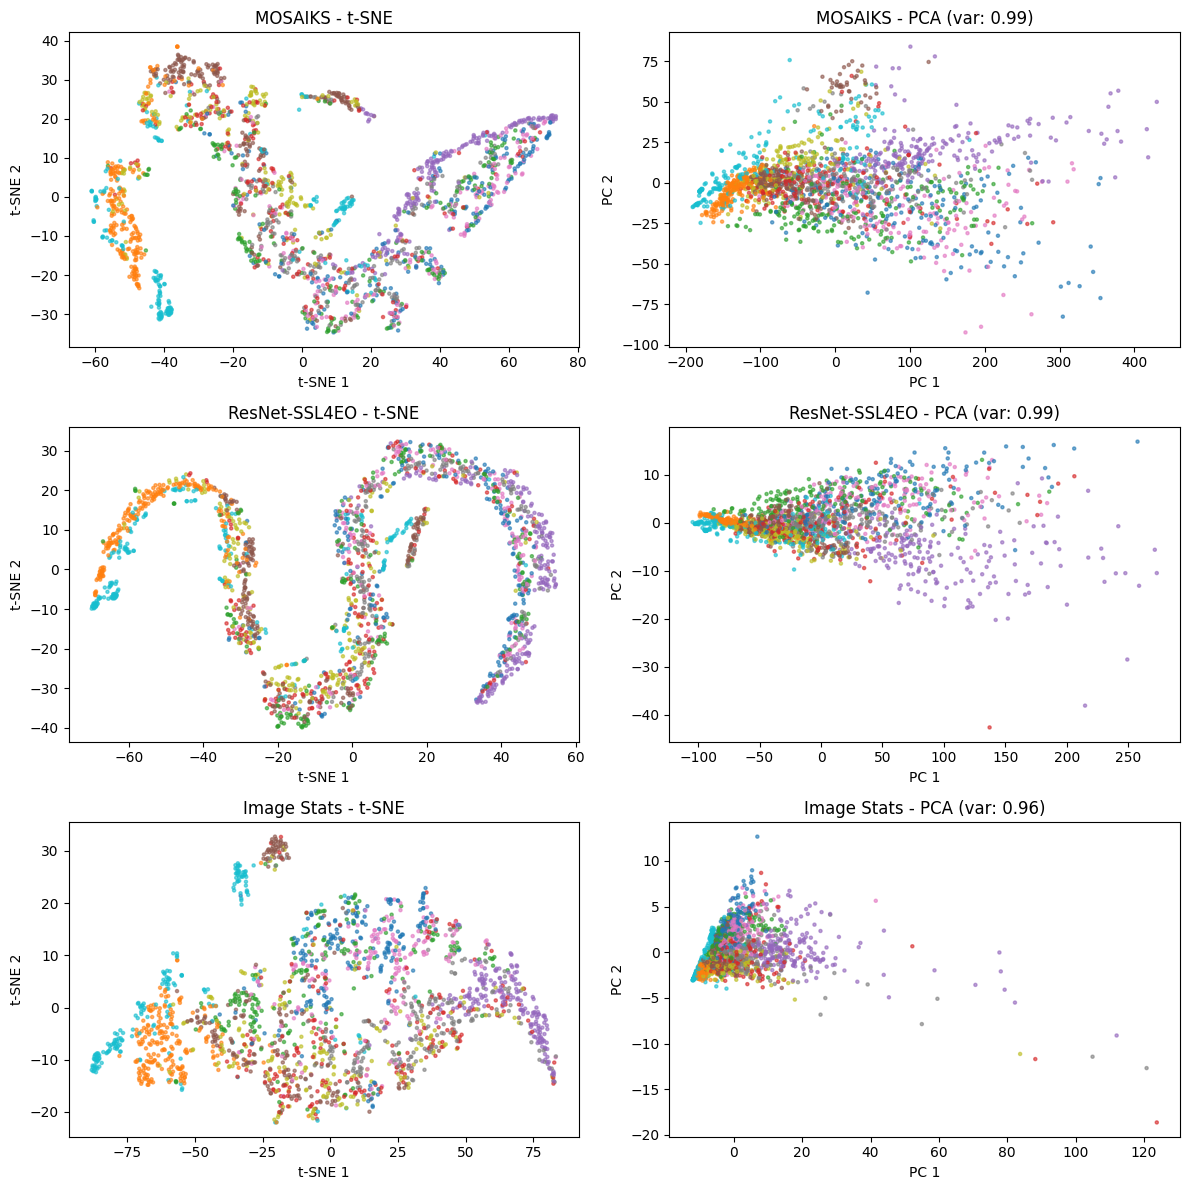

  Saved visualization to ./embeddings/embeddings_visualization.png
Pipeline completed!


In [38]:
# Run evaluation
if len(labels) > 0:
    features_dict = {
        'MOSAIKS': mosaiks_features,
        'ResNet-SSL4EO': resnet_features,
        'Image Stats': stats_features
    }

    results = evaluate_embeddings(features_dict, labels)
    visualize_embeddings(features_dict, labels, config.output_dir, max_samples=2000)

print("Pipeline completed!")